In [5]:
import requests
import re # Can encounter XML namespaces... use regex
from bs4 import BeautifulSoup

# 13F-HR Parsing
The main information in a 13F holding report is in the information table, SEC reference [here](https://www.sec.gov/about/forms/form13f.pdf). Perhaps grabbing data in relation to "other managers" (combination style report) may also be of use but for now we will simply focus on the positions themselves. See [here](https://www.sec.gov/divisions/investment/13ffaq) for FAQ on 13F filings. This method targets the full text 13F filing documents (containing the cover page, summary, and information table(s)). As per the FAQ, 13F's before May 20, 2013 are in a raw text format which is far less structured, requires more parsing, and can vary by filer. Most likely will add methods to accomodate at least some of these legacy 13F's but for now am focusing on the modern XML-based format. 

In [6]:
"""
Retrieves positions from modern (AKA those with XML information table) 13F-HR's
Given the URL to the full text filing, returns a list of dictionaries of the following structure:

{
  "issuer" : "APPLE INC",
  "class" : "COM", # Or "SHS CLASS A" etc. In some cases, PUT/CALL will be here as well as optiontype 
  "cusip" : "CUSIP",
  "value" : "POSITION_VALUE_IN_THOUSANDS",
  "amount" : "NUM_OF_SECURITY_OWNED",
  "amttype" : "SH/PRN",
  "optiontype" : "" # "CALL/PUT" if an option position
}
"""
def info_table_from_fulltxt(fulltxt_url):

  # List to be returned 
  master_list = []
  
  # Get full text content
  request_headers = { "User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36" }
  response = requests.get(url = fulltxt_url, headers = request_headers)
  response.raise_for_status()

  # NOTE: Lowercase the text
  fulltxt_content = response.text.lower()

  # Split by "<document>"
  split_docs = fulltxt_content.split("<document>")
  if len(split_docs) == 0:
    print("Failed to find a <document> tag in {}. Check file format".format(fulltxt_url))
    return master_list

  for doc in split_docs:

    # Find doc of type "information table"
    if "<type>information table" in doc:

      # Jump into XML tag
      split_it = doc.split("<xml>")
      if len(split_it) < 2:
        print("Failed to split information table for {}. Check file format".format(fulltxt_url))
        return []

      # Clean it up 
      stripped_xml = split_it[1].replace("</xml>", "").replace("</text>", "").replace("</document>", "").replace("</sec-document>", "").strip()
      
      # Get root informationtable, holds one infotable child per position/holding
      soup = BeautifulSoup(stripped_xml, 'lxml')
      parent_infotable = soup.find(re.compile("informationtable"))

      if len(parent_infotable) == 0:
        print("Failed to find <informationTable> of {}. Check file format".format(fulltxt_url))
        return master_list

      # Loop through the child infotables
      positions_list = parent_infotable.find_all(re.compile("infotable"))
      if len(positions_list) == 0:
        print("No holdings found in info table of {}".format(fulltxt_url))
        return master_list

      for position_index, position in enumerate(positions_list):

        # Create a dict for the position infotable
        holding = {
            "issuer" : "",
            "class" : "",
            "cusip" : "",
            "value" : "",
            "amount" : "",
            "amttype" : "",
            "optiontype" : ""
        }

        # Fill it
        try:
          holding["issuer"] = position.find(re.compile("nameofissuer")).text.strip()
          holding["class"] = position.find(re.compile("titleofclass")).text.strip()
          holding["cusip"] = position.find(re.compile("cusip")).text.strip()
          holding["value"] = position.find(re.compile("value")).text.strip()
          holding["amount"] = position.find(re.compile("sshprnamt")).text.strip()
          holding["amttype"] = position.find(re.compile("sshprnamttype")).text.strip()
          optiontype = position.find(re.compile("putcall"))
          if optiontype:
            holding["optiontype"] = optiontype.text.strip()
        except:
          print("Failed reading values of position #{} in {}. Skipping".format(position_index + 1, fulltxt_url))
          continue
        
        # All caps and append to master
        for key, value in holding.items():
          holding[key] = value.upper()
        master_list.append(holding)

  return master_list

In [ ]:
print(info_table_from_fulltxt("https://www.sec.gov/Archives/edgar/data/1532472/000153247222000004/0001532472-22-000004.txt")) # HAS NAMESPACE
#print(info_table_from_fulltxt("https://www.sec.gov/Archives/edgar/data/1715593/000171559322000005/0001715593-22-000005.txt")) # NO NAMESPACE
#print(info_table_from_fulltxt("https://www.sec.gov/Archives/edgar/data/1446194/000144619422000005/0001446194-22-000005.txt")) # HAS OPTIONS

# Comparing Holdings Across Time
I have written a few methods to compare a fund's 13F-HR's across time, particularly looking for changes in position sizes or dollar values. 

The methods I have included in this notebook find the previous 13F-HR to the one being examined, but the same logic of utilizing the submissions API to compare any number of previous 13F's is possible. 

In [7]:
# Supports the below find_previous_hr in the case that the filer has more than 1,000 filings in their submission history and the previous 13F-HR is not one of the first 1,000
def traverse_extended_submissions(ext_sub_uri, current_hr_cik, current_hr_date):
    
    # To be returned
    path_to_previous = ""

    # Base URL to build returned path with
    base_archive_url = r"https://www.sec.gov/Archives/edgar/data/{}/".format(current_hr_cik.zfill(10))
    
    # Build extended submissions URL
    submissions_url = r"https://data.sec.gov/submissions/{}".format(ext_sub_uri)
    request_headers = { "User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36" }

    # Get the JSON data
    response = requests.get(url = submissions_url, headers = request_headers)
    response.raise_for_status()

    json_data = response.json()

    # Again, grab the 3 lists we are interested in and look for a 13F-HR older than current_hr_date
    try:
        date_list = json_data['filings']['recent']['filingDate'] # Note that dates returned by the submissions API are in ISO format, while those from jidx do not contain dashes
        accession_list = json_data['filings']['recent']['accessionNumber']
        form_code_list = json_data['filings']['recent']['form']
    except:
        print("Unexpected response format from submissions RESTful API call: {}".format(response.url))
        return path_to_previous

    # Convert current_hr_date to an integer for comparison. In ISO format without dashes, after casting to an integer, newest dates would be greater values than older dates
    # 20221001 > 20220930 > 20211010 > etc
    anchor_date_int = int(current_hr_date)

    # Loop through form codes, comparing to "13F-HR". Most recent filings will come first
    for filing_index, form_code in enumerate(form_code_list):
        if form_code == "13F-HR":

            # Grab date and convert to int
            found_date_int = int(date_list[filing_index].replace("-", ""))

            # If the found date is older (less) than the anchor, we've found our match
            if anchor_date_int > found_date_int:
                path_to_previous = base_archive_url + accession_list[filing_index] + ".txt"
                return path_to_previous

    # Failure
    return path_to_previous

In [8]:
# Takes the a CIK and the date of a 13F-HR and attempts to return a path to the raw fulltext version of the filer's previous 13F-HR
# Utilizes the submissions RESTful API
def find_previous_hr(current_hr_cik, current_hr_date):

    # To be returned
    path_to_previous = ""

    # Base URL to build returned path with
    base_archive_url = r"https://www.sec.gov/Archives/edgar/data/{}/".format(current_hr_cik.zfill(10))
    
    # Build submissions URL
    submissions_url = r"https://data.sec.gov/submissions/CIK{}.json".format(current_hr_cik.zfill(10))

    # Request
    request_headers = { "User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36" }
    response = requests.get(url = submissions_url, headers = request_headers)
    response.raise_for_status()

    json_data = response.json()

    # Grab the 3 lists we are interested in. They should be indexed/aligned in correlation with eachother, i.e. date_list[1] should correlate to form_code_list[1]
    try:
        date_list = json_data['filings']['recent']['filingDate'] # Note that dates returned by the submissions API are in ISO format, while those from jidx do not contain dashes
        accession_list = json_data['filings']['recent']['accessionNumber']
        form_code_list = json_data['filings']['recent']['form']
    except:
        print("Unexpected response format from submissions RESTful API call: {}".format(response.url))
        return path_to_previous

    # Convert current_hr_date to an integer for comparison. In ISO format without dashes (as held in .idx files), after casting to an integer, newest dates would be greater values than older dates
    # 20221001 > 20220930 > 20211010 > etc
    anchor_date_int = int(current_hr_date)

    # Loop through form codes, comparing to "13F-HR". Most recent filings will come first
    for filing_index, form_code in enumerate(form_code_list):
        if form_code == "13F-HR":

            # Grab date and convert to int
            found_date_int = int(date_list[filing_index].replace("-", ""))

            # If the found date is older (less) than the anchor, we've found our match
            if anchor_date_int > found_date_int:
                path_to_previous = base_archive_url + accession_list[filing_index] + ".txt"
                return path_to_previous

    # In case there were more than 1,000 (or if there are filings for some other reason in there) check filings->files for links to additional
    # Each entry in "files" contains "name" field with URI of another JSON file set up like submissions/CIK###.json 
    try:
        for ext_link in json_data['filings']['files']:
            traverse_extended_submissions(ext_sub_uri = ext_link['name'], current_hr_cik = current_hr_cik, current_hr_date = current_hr_date)
    except:
        pass

    return path_to_previous

In [9]:
"""
Takes 2 list of positions dicts and finds differences in positions or their sizes. Note that a difference in size and dollar value of a position will default to the change being grouped under a change in size 
(rather than a change in value). 
The structure of the returned dict is as follows:
{
    "new_pos" : [ # List of positions which did not previously exist
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held
            "new_val" : "" # Value of new position in thousands
        }
    ], 
    "dropped_pos" : [ # List of positions which no longer exist
        {
            "cusip" : "", # CUSIP of security
            "prev_amt" : "", # Previously held amount
            "prev_val" : "" # Value of previously held position in thousands
        }
    ],
    "inc_pos" : [ # List of positions of which the size/amount held has increased
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held
            "prev_amt" : "", # Previously held amount
            "new_val" : "", # Value of increased position in thousands
            "prev_val" : "" # Value of position before increase in size, in thousands
        }
    ],
    "dec_pos" : [ # List of positions of which the size/amount held has decreased
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held
            "prev_amt" : "" # Previously held amount
            "new_val" : "", # Value of decreased position in thousands
            "prev_val" : "" # Value of position before decrease in size, in thousands
        }
    ], 
    "same_incv" : [ # List of positions which are unchanged in size from the last holdings report, but the value has increased
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held (same as prev_amt)
            "prev_amt" : "", # Previously held amount (same as new_amt)
            "new_val" : "", # New, increased value of position
            "prev_val" : "" # Old, lesser value of position
        }
    ],
    "same_decv" : [ # List of positions which are unchanged in size from the last holdings report, but the value has decreased
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held (same as prev_amt)
            "prev_amt" : "", # Previously held amount (same as new_amt)
            "new_val" : "", # New, decreased value of position
            "prev_val" : "" # Old, greater value of position
        }
    ],
    "same_samev" : [ # List of positions which are unchanged in both size and value from last holdings report
        {
            "cusip" : "", # CUSIP of security
            "new_amt" : "", # Amount now held (same as prev_amt)
            "prev_amt" : "", # Previously held amount (same as new_amt)
            "new_val" : "", # New value of position (same as prev_val)
            "prev_val" : "" # Old value of position (same as new_val)
        }
    ]
}
"""
def compare_two_position_lists(new_positions = (), old_positions = ()):
    
    # Structure to return
    master_diff_dict = {
        "new_pos" : [],
        "dropped_pos" : [],
        "inc_pos" : [],
        "dec_pos" : [],
        "same_incv" : [],
        "same_decv" : [],
        "same_samev" : []
    }

    # Loop through positions in current HR
    for newer_pos in new_positions:
        cur_cusip = newer_pos.get("cusip").upper()
        cur_val = newer_pos.get("value")
        cur_amt = newer_pos.get("amount")
        is_new = True

        # Locate existing positions
        for older_pos in old_positions:
            if older_pos.get("cusip").upper() == cur_cusip:

                # Flip flag if same CUSIP found in previous holdings report
                is_new = False

                # Also, knowing the position is not new, check if it is increased, decreased, or unchanged in size or value
                old_val = older_pos.get("value")
                old_amt = older_pos.get("amount")

                existing_pos_dict = {}
                existing_pos_dict["cusip"] = cur_cusip
                existing_pos_dict["new_amt"] = cur_amt
                existing_pos_dict["prev_amt"] = old_amt
                existing_pos_dict["new_val"] = cur_val
                existing_pos_dict["prev_val"] = old_val

                # Increased size
                if int(cur_amt) > int(old_amt):
                    master_diff_dict["inc_pos"].append(existing_pos_dict)

                # Decreased size
                elif int(cur_amt) < int(old_amt):
                    master_diff_dict["dec_pos"].append(existing_pos_dict)

                # Unchanged size. Determine if value has changed
                else:
                    pass
                    
                    # Increased value
                    if int(cur_val) > int(old_val):
                        master_diff_dict["same_incv"].append(existing_pos_dict)
                    
                    # Decreased value
                    elif int(cur_val) < int(old_val):
                        master_diff_dict["same_decv"].append(existing_pos_dict)
                    
                    # Unchanged value
                    else:
                        master_diff_dict["same_samev"].append(existing_pos_dict)
        
        # Found a new position if this was not tripped to false
        if is_new:

            new_pos_dict = {}
            new_pos_dict["cusip"] = cur_cusip
            new_pos_dict["new_amt"] = cur_amt
            new_pos_dict["new_val"] = cur_val

            master_diff_dict["new_pos"].append(new_pos_dict)

    # Now dropped positions
    for prev_pos in old_positions:
        old_cusip = prev_pos.get("cusip").upper()
        old_val = prev_pos.get("value")
        old_amt = prev_pos.get("amount")
        is_dropped = True

        for new_pos in new_positions:
            if new_pos.get("cusip").upper() == old_cusip:
                is_dropped = False
        
        # Position is dropped if this was not tripped to false
        if is_dropped:

            dropped_pos_dict = {}
            dropped_pos_dict["cusip"] = old_cusip
            dropped_pos_dict["prev_amt"] = old_amt
            dropped_pos_dict["prev_val"] = old_val

            master_diff_dict["dropped_pos"].append(dropped_pos_dict)

    return master_diff_dict

In [ ]:
# POC comparing given 13F-HR to previously filed
cik = "0001715593"
current_holdings_date = "20221004" # In format found on master daily index (idx) files, ISO without dashes
current_holdings = info_table_from_fulltxt("https://www.sec.gov/Archives/edgar/data/0001715593/0001715593-22-000005.txt")

prev_holdings_path = find_previous_hr(cik, current_holdings_date)
if prev_holdings_path:
  prev_holdings = info_table_from_fulltxt(prev_holdings_path)

  holdings_changes = compare_two_position_lists(current_holdings, prev_holdings)
  display(holdings_changes)

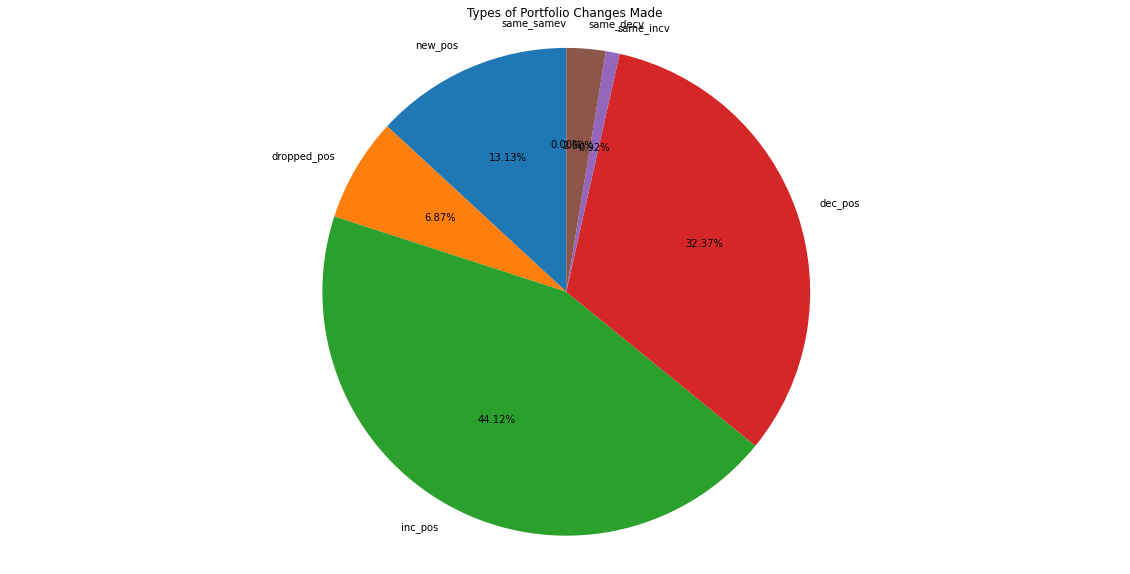

In [12]:
# POC visualizing types of changes between two 13F-HR's, simple pie chart
import matplotlib.pyplot as plt

cik = "0001715593"
current_holdings_date = "20221004" # In format found on master daily index (idx) files, ISO without dashes
current_holdings = info_table_from_fulltxt("https://www.sec.gov/Archives/edgar/data/0001715593/0001715593-22-000005.txt")

prev_holdings_path = find_previous_hr(cik, current_holdings_date)
if prev_holdings_path:
  prev_holdings = info_table_from_fulltxt(prev_holdings_path)

  # Get changes
  holdings_changes = compare_two_position_lists(current_holdings, prev_holdings)

  

  # Count changes of each type
  change_counts = [len(x) for x in list(holdings_changes.values())]
  change_labels = list(holdings_changes.keys())

  plt.rcParams["figure.figsize"] = (20,10) # Set default figure size
  plt.pie(change_counts, labels = change_labels, startangle = 90, autopct = "%1.2f%%")
  plt.axis("equal")
  plt.title("Types of Portfolio Changes Made")
  plt.show()